In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
import random

2023-11-20 13:23:48.539490: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 13:23:48.541010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 13:23:48.569498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 13:23:48.570035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 13:23:49.275976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# GLOBAL VARIABLES 
os.chdir("/home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject")
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 
outputDirectories = ["archive/tom_and_jerry/tom_and_jerry/jerry", 
                     "archive/tom_and_jerry/tom_and_jerry/tom", 
                    #  "archive/tom_and_jerry/tom_and_jerry/tom_jerry_0",
                     "archive/tom_and_jerry/tom_and_jerry/tom_jerry_1"]

# directories containing edge-filtered images
inputDirectories = ["archive/tom_and_jerry/tom_and_jerry_edge_detected/jerry_edge_detected", 
                    "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_edge_detected", 
                    # "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_0_edge_detected",
                    "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_1_edge_detected"]


Working Directory: /home/linus/WashUCoding/DIS Copenhagen/Neural Networks/TomJerryProject


In [4]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    # beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [5]:
paths = getFilePaths()
maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [6]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []

imagesProcessed = 0
totalImagePairs = len(paths)

personal_image_shape = (100, 50)
for inputImagePath, outputImagePath in paths: 
    inputImage, imageLabel = loadImage(inputImagePath, outputImagePath, image_shape=personal_image_shape, isRGB=False)

    # if validation_split = 0.2, put 80% of images into the training dataset
    if imagesProcessed / totalImagePairs > validation_split: 
        x_train.append(inputImage)
        y_train.append(imageLabel)
    # else, put the images into the testing dataset
    else: 
        x_test.append(inputImage)
        y_test.append(imageLabel)
        
    imagesProcessed += 1


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [7]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

3159 3159
791 791
(3159, 50, 100)
(3159, 50, 100)
(791, 50, 100)
(791, 50, 100)


In [8]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
class AutoencoderWithDense(Model):
    def __init__(self, latent_dim, dropout_rate=0.2):
        super(AutoencoderWithDense, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(512, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(512, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            # layers.Dense(personal_image_shape[1] * personal_image_shape[0], activation='sigmoid'),
            layers.Dense(personal_image_shape[1] * personal_image_shape[0], activation='relu'),
            layers.Reshape((personal_image_shape[1], personal_image_shape[0])) # is reversed from other functions
            # layers.Reshape((100, 200)) # is reversed from other functions
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
autoencoder_with_dense = AutoencoderWithDense(latent_dim = 250)
autoencoder_with_dense.compile(optimizer='adam', 
                               loss=losses.MeanSquaredError())
                              #  loss=losses.MeanAbsoluteError())
                              #  loss=losses.BinaryCrossentropy())

callback = EarlyStopping(monitor="val_loss", patience = 15)

history = autoencoder_with_dense.fit(train_dataset,
                epochs=1000,
                shuffle=True,
                validation_data=(test_dataset), 
                callbacks=callback)


Epoch 1/1000
50/50 [==============================] - 3s 47ms/step - loss: 0.0830 - val_loss: 0.0461
Epoch 2/1000
50/50 [==============================] - 2s 44ms/step - loss: 0.0367 - val_loss: 0.0348
Epoch 3/1000
50/50 [==============================] - 2s 44ms/step - loss: 0.0304 - val_loss: 0.0299
Epoch 4/1000
50/50 [==============================] - 2s 45ms/step - loss: 0.0294 - val_loss: 0.0303
Epoch 5/1000
50/50 [==============================] - 2s 48ms/step - loss: 0.0292 - val_loss: 0.0293
Epoch 6/1000
50/50 [==============================] - 2s 44ms/step - loss: 0.0288 - val_loss: 0.0290
Epoch 7/1000
50/50 [==============================] - 2s 43ms/step - loss: 0.0276 - val_loss: 0.0289
Epoch 8/1000
50/50 [==============================] - 2s 44ms/step - loss: 0.0276 - val_loss: 0.0281
Epoch 9/1000
50/50 [==============================] - 2s 44ms/step - loss: 0.0276 - val_loss: 0.0273
Epoch 10/1000
50/50 [==============================] - 2s 46ms/step - loss: 0.0262 - val_lo

25/25 [==============================] - 0s 6ms/step
0.0 0.64151204
0.0 0.6109904


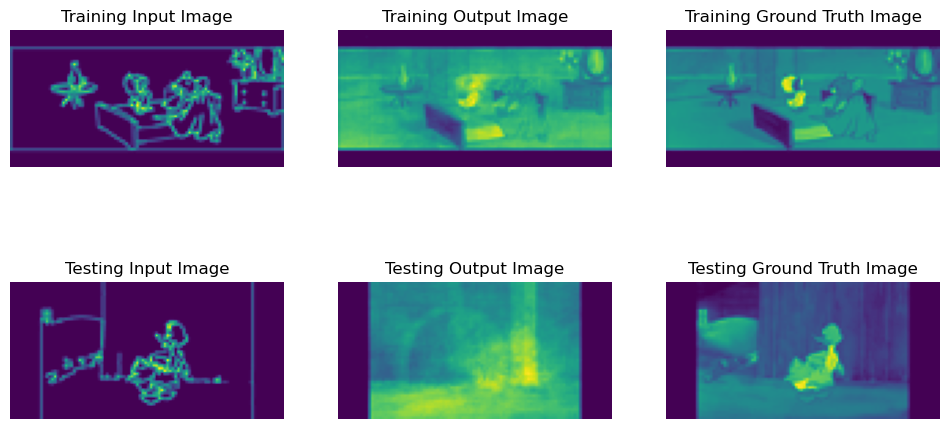

In [22]:
# Display images for testing

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = autoencoder_with_dense.predict(x_train)[trainImageIndex]
test_output_image = autoencoder_with_dense.predict(x_test)[testImageIndex]
print(np.min(np.array(train_output_image)), np.max(np.array(train_output_image)))
print(np.min(np.array(test_output_image)), np.max(np.array(test_output_image)))
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [34]:
autoencoder_with_dense.save("src/SavedModels/DenseModel2.keras")